In [71]:
import json
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
%matplotlib inline

# Carga de los conjuntos de datos

In [2]:
t_start = time()
train_data = pd.read_csv('./datasets/en_data_train.csv', sep='\s*,\s*', header=0, encoding='ascii', engine='python')
test_data = pd.read_csv('./datasets/en_data_test.csv', sep='\s*,\s*', header=0, encoding='ascii', engine='python')
test_data_spanish = pd.read_csv('./datasets/es_data_test.csv', sep='\s*,\s*', header=0, encoding='ascii', engine='python')
test_data_arab = pd.read_csv('./datasets/ar_data_test.csv', sep='\s*,\s*', header=0, encoding='ascii', engine='python')
print("{} segundos cargando los conjuntos de datos".format(time() - t_start))

Han tomado 82.66241264343262 segundos cargando los conjunto de datos


# Clasificación usando vectores promedio 

In [3]:
def create_avg_dataset(dataframe, json_labels_file_path):
    X = dataframe.groupby('author_id').mean()
    with open(json_labels_file_path) as json_file:
        dict_of_labels = json.loads(json_file.read())
    y = [dict_of_labels[author_id] for author_id, row in X.iterrows()]
    return X, y

In [4]:
X, y = create_avg_dataset(train_data, './authors_labels/en_train_labels.json')
X_test, y_test = create_avg_dataset(test_data, './authors_labels/en_test_labels.json')
X_test_spanish, y_test_spanish = create_avg_dataset(test_data_spanish, './authors_labels/es_test_labels.json')
X_test_arab, y_test_arab = create_avg_dataset(test_data_arab, './authors_labels/ar_test_labels.json')

## Entrenamiento de la SVM (promedios)

In [13]:
from sklearn.svm import SVC
t_start = time()
svclassifier = SVC(kernel='linear')
svclassifier.fit(X, y)
joblib.dump(svclassifier, 'svm_kernel_lin_avg.sav')
print("{} seconds training SVM".format(time() - t_start))

11.848257064819336 seconds training SVM


## Prueba monolingüe (inglés - inglés)

In [6]:
y_pred = svclassifier.predict(X_test)

In [7]:
print("Matriz de confusión")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Exactitud {}".format(accuracy_score(y_test, y_pred)))


Matriz de confusión
[[682 268]
 [413 537]]
              precision    recall  f1-score   support

      female       0.62      0.72      0.67       950
        male       0.67      0.57      0.61       950

   micro avg       0.64      0.64      0.64      1900
   macro avg       0.64      0.64      0.64      1900
weighted avg       0.64      0.64      0.64      1900

Exactitud 0.641578947368421


## Prueba crosslingüe (inglés - español)

In [8]:
y_pred_spanish = svclassifier.predict(X_test_spanish)

In [9]:
print("Matriz de confusión")
print(confusion_matrix(y_test_spanish, y_pred_spanish))  
print(classification_report(y_test_spanish, y_pred_spanish))
print("Exactitud {}".format(accuracy_score(y_test_spanish, y_pred_spanish)))

Matriz de confusión
[[728 372]
 [470 630]]
              precision    recall  f1-score   support

      female       0.61      0.66      0.63      1100
        male       0.63      0.57      0.60      1100

   micro avg       0.62      0.62      0.62      2200
   macro avg       0.62      0.62      0.62      2200
weighted avg       0.62      0.62      0.62      2200

Exactitud 0.6172727272727273


## Prueba crosslingüe (inglés - árabe)

In [10]:
y_pred_arab = svclassifier.predict(X_test_arab)

In [12]:
print("Matriz de confusión")
print(confusion_matrix(y_test_arab, y_pred_arab))  
print(classification_report(y_test_arab, y_pred_arab))
print("Exactitud {}".format(accuracy_score(y_test_arab, y_pred_arab)))

Matriz de confusión
[[378 122]
 [247 253]]
              precision    recall  f1-score   support

      female       0.60      0.76      0.67       500
        male       0.67      0.51      0.58       500

   micro avg       0.63      0.63      0.63      1000
   macro avg       0.64      0.63      0.63      1000
weighted avg       0.64      0.63      0.63      1000

Exactitud 0.631


In [92]:
top_n = 50
freq_instances = train_data.groupby('class').sum()
females_freqs = freq_instances.loc["female", :]
males_freqs = freq_instances.loc["male", :]
males_freqs = males_freqs.sort_values(ascending=False)
males_top_n_categories = males_freqs.keys()[:top_n]
females_freqs = females_freqs.sort_values(ascending=False)
females_top_n_categories = females_freqs.keys()[:top_n]


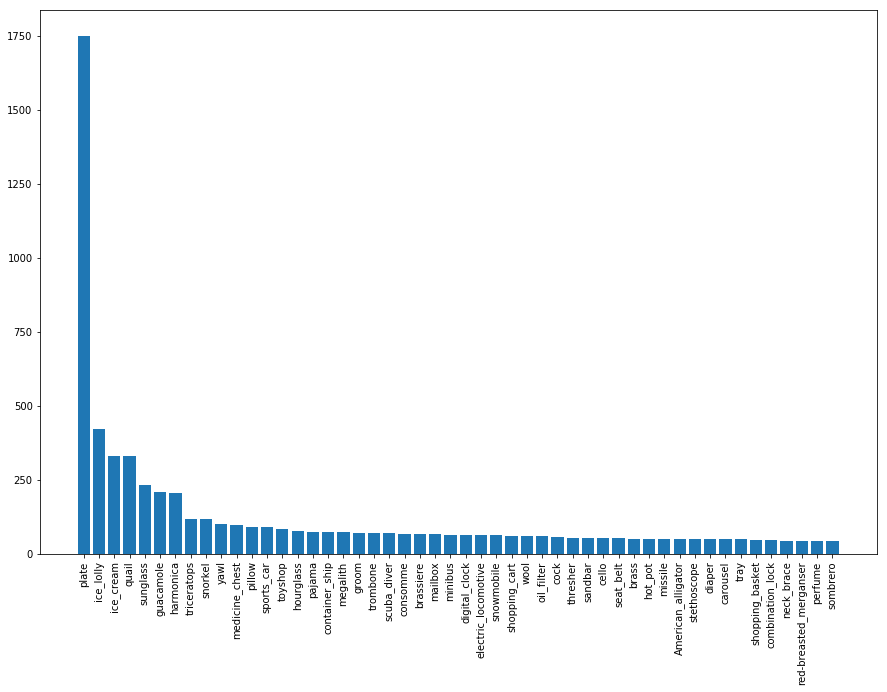

In [93]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.bar(males_top_n_categories, males_freqs[:top_n])
plt.xticks(np.arange(top_n), males_top_n_categories, rotation=90)
plt.show()

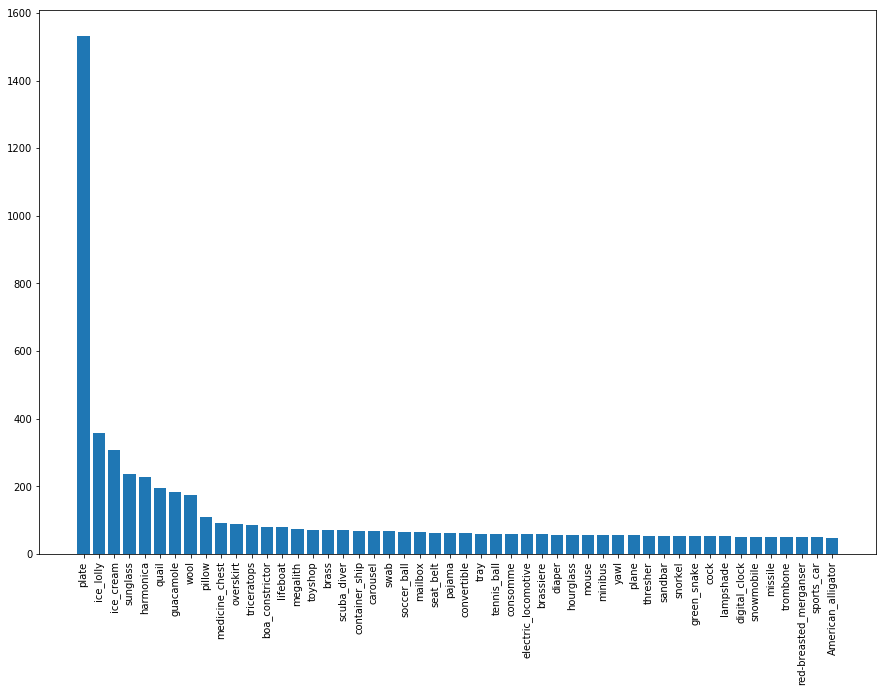

In [94]:
plt.bar(females_top_n_categories, females_freqs[:top_n])
plt.xticks(np.arange(top_n), females_top_n_categories, rotation=90)
plt.show()

In [95]:
print("Intersección {}".format(len(set(males_top_n_categories).intersection(set(females_top_n_categories)))))
males_categories = [c for c in males_top_n_categories if c not in females_top_n_categories]
female_categories = [c for c in females_top_n_categories if c not in males_top_n_categories]

Intersección 39


In [96]:
from IPython.display import HTML

table_male_str = """<table>
<tr>
<th>Categoría</th>
<th>Frecuencia</th>
</tr>"""

for c in males_categories:
    table_male_str += "<tr>"
    table_male_str += "<td>{}</td><td>{}</td>".format(c, males_freqs[c])
    table_male_str += "</tr>"
table_male_str += "</table>"
display(HTML(table_male_str))

Categoría,Frecuencia
groom,72.44342752419004
shopping_cart,60.74565640584823
oil_filter,60.53889946001986
cello,53.141096213218056
hot_pot,51.47380112400642
stethoscope,50.39318299785728
shopping_basket,48.26079360242036
combination_lock,46.38231095331661
neck_brace,45.39472548090854
perfume,45.165538402702204


In [97]:
table_female_str = """<table>
<tr>
<th>Categoría</th>
<th>Frecuencia</th>
</tr>"""

for c in female_categories:
    table_female_str += "<tr>"
    table_female_str += "<td>{}</td><td>{}</td>".format(c, females_freqs[c])
    table_female_str += "</tr>"
table_female_str += "</table>"
display(HTML(table_female_str))

Categoría,Frecuencia
overskirt,88.71891950732783
boa_constrictor,80.22119333981502
lifeboat,80.10764028360377
swab,67.003732118767
soccer_ball,65.31967500968747
convertible,60.98693039084846
tennis_ball,59.66141816176521
mouse,55.92154345924264
plane,55.543063510954006
green_snake,52.533228052552325


In [98]:
import pickle
loaded_model = joblib.load('svm_kernel_lin.sav')
result = loaded_model.score(X_test, y_test)